In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

# 데이터 분포 확인을 위한 plt 라이브러리 import 
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
orders = pd.read_csv("olist_orders_dataset.csv")
order_items = pd.read_csv("olist_order_items_dataset.csv")
payments = pd.read_csv("olist_order_payments_dataset.csv")
reviews = pd.read_csv("olist_order_reviews_dataset.csv")
customers = pd.read_csv("olist_customers_dataset.csv")

In [3]:
# 주문 + 리뷰
df = orders.merge(
    reviews[["order_id", "review_score"]],
    on="order_id",
    how="left"
)
df

order_id                       customer_id  \
0      e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1      53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2      47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3      949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4      ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   
...                                 ...                               ...   
99987  9c5dedf39a927c1b2549525ed64a053c  39bd1228ee8140590ac3aca26f2dfe00   
99988  63943bddc261676b46f01ca7ac2f7bd8  1fca14ff2861355f6e5f14306ff977a7   
99989  83c1379a015df1e13d02aae0204711ab  1aa71eb042121263aafbe80c1b562c9c   
99990  11c177c8e97725db2631073c19f07b62  b331b74b18dc79bcdf6532d51e1637c1   
99991  66dea50a8b16d9b4dee7af250b4be1a5  edb027a75a1449115f6b43211ae02a24   

      order_status order_purchase_timestamp    order_approved_at  \
0        delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
1        delivered      2018-07-24 20:41:37  2018-07-26 03:24:27   
2        delivered      2018-08-08 08:38:49  2018-08-08 08:55:23   
3        delivered      2017-11-18 19:28:06  2017-11-18 19:45:59   
4        delivered      2018-02-13 21:18:39  2018-02-13 22:20:29   
...            ...                      ...                  ...   
99987    delivered      2017-03-09 09:54:05  2017-03-09 09:54:05   
99988    delivered      2018-02-06 12:58:58  2018-02-06 13:10:37   
99989    delivered      2017-08-27 14:46:43  2017-08-27 15:04:16   
99990    delivered      2018-01-08 21:28:27  2018-01-08 21:36:21   
99991    delivered      2018-03-08 20:57:30  2018-03-09 11:20:28   

      order_delivered_carrier_date order_delivered_customer_date  \
0              2017-10-04 19:55:00           2017-10-10 21:25:13   
1              2018-07-26 14:31:00           2018-08-07 15:27:45   
2              2018-08-08 13:50:00           2018-08-17 18:06:29   
3              2017-11-22 13:39:59           2017-12-02 00:28:42   
4              2018-02-14 19:46:34           2018-02-16 18:17:02   
...                            ...                           ...   
99987          2017-03-10 11:18:03           2017-03-17 15:08:01   
99988          2018-02-07 23:22:42           2018-02-28 17:37:56   
99989          2017-08-28 20:52:26           2017-09-21 11:24:17   
99990          2018-01-12 15:35:03           2018-01-25 23:32:54   
99991          2018-03-09 22:11:59           2018-03-16 13:08:30   

      order_estimated_delivery_date  review_score  
0               2017-10-18 00:00:00           4.0  
1               2018-08-13 00:00:00           4.0  
2               2018-09-04 00:00:00           5.0  
3               2017-12-15 00:00:00           5.0  
4               2018-02-26 00:00:00           5.0  
...                             ...           ...  
99987           2017-03-28 00:00:00           5.0  
99988           2018-03-02 00:00:00           4.0  
99989           2017-09-27 00:00:00           5.0  
99990           2018-02-15 00:00:00           2.0  
99991           2018-04-03 00:00:00           5.0  

[99992 rows x 9 columns]

In [4]:
## 주문 아이템 요약 (주문 구조)
order_item_summary = (
    order_items
    .groupby("order_id")
    .agg(
        n_items=("order_item_id", "count"),  # 주문 상품 수
        n_sellers=("seller_id", "nunique"),  # 판매자 수
        total_price=("price", "sum"),  # 주문 금액
        total_freight=("freight_value", "sum")  # 배송비
    )
    .reset_index()
)

df = df.merge(order_item_summary, on="order_id", how="left")
df

order_id                       customer_id  \
0      e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1      53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2      47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3      949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4      ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   
...                                 ...                               ...   
99987  9c5dedf39a927c1b2549525ed64a053c  39bd1228ee8140590ac3aca26f2dfe00   
99988  63943bddc261676b46f01ca7ac2f7bd8  1fca14ff2861355f6e5f14306ff977a7   
99989  83c1379a015df1e13d02aae0204711ab  1aa71eb042121263aafbe80c1b562c9c   
99990  11c177c8e97725db2631073c19f07b62  b331b74b18dc79bcdf6532d51e1637c1   
99991  66dea50a8b16d9b4dee7af250b4be1a5  edb027a75a1449115f6b43211ae02a24   

      order_status order_purchase_timestamp    order_approved_at  \
0        delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
1        delivered      2018-07-24 20:41:37  2018-07-26 03:24:27   
2        delivered      2018-08-08 08:38:49  2018-08-08 08:55:23   
3        delivered      2017-11-18 19:28:06  2017-11-18 19:45:59   
4        delivered      2018-02-13 21:18:39  2018-02-13 22:20:29   
...            ...                      ...                  ...   
99987    delivered      2017-03-09 09:54:05  2017-03-09 09:54:05   
99988    delivered      2018-02-06 12:58:58  2018-02-06 13:10:37   
99989    delivered      2017-08-27 14:46:43  2017-08-27 15:04:16   
99990    delivered      2018-01-08 21:28:27  2018-01-08 21:36:21   
99991    delivered      2018-03-08 20:57:30  2018-03-09 11:20:28   

      order_delivered_carrier_date order_delivered_customer_date  \
0              2017-10-04 19:55:00           2017-10-10 21:25:13   
1              2018-07-26 14:31:00           2018-08-07 15:27:45   
2              2018-08-08 13:50:00           2018-08-17 18:06:29   
3              2017-11-22 13:39:59           2017-12-02 00:28:42   
4              2018-02-14 19:46:34           2018-02-16 18:17:02   
...                            ...                           ...   
99987          2017-03-10 11:18:03           2017-03-17 15:08:01   
99988          2018-02-07 23:22:42           2018-02-28 17:37:56   
99989          2017-08-28 20:52:26           2017-09-21 11:24:17   
99990          2018-01-12 15:35:03           2018-01-25 23:32:54   
99991          2018-03-09 22:11:59           2018-03-16 13:08:30   

      order_estimated_delivery_date  review_score  n_items  n_sellers  \
0               2017-10-18 00:00:00           4.0      1.0        1.0   
1               2018-08-13 00:00:00           4.0      1.0        1.0   
2               2018-09-04 00:00:00           5.0      1.0        1.0   
3               2017-12-15 00:00:00           5.0      1.0        1.0   
4               2018-02-26 00:00:00           5.0      1.0        1.0   
...                             ...           ...      ...        ...   
99987           2017-03-28 00:00:00           5.0      1.0        1.0   
99988           2018-03-02 00:00:00           4.0      1.0        1.0   
99989           2017-09-27 00:00:00           5.0      1.0        1.0   
99990           2018-02-15 00:00:00           2.0      2.0        1.0   
99991           2018-04-03 00:00:00           5.0      1.0        1.0   

       total_price  total_freight  
0            29.99           8.72  
1           118.70          22.76  
2           159.90          19.22  
3            45.00          27.20  
4            19.90           8.72  
...            ...            ...  
99987        72.00          13.08  
99988       174.90          20.10  
99989       205.99          65.02  
99990       359.98          81.18  
99991        68.50          18.36  

[99992 rows x 13 columns]

In [5]:
## 결제 정보 요약
payment_summary = (
    payments
    .groupby("order_id")
    .agg(
        payment_type=("payment_type", lambda x: x.mode()[0]),  # 같은 주문 안에서 가장 많이 사용된 결제 수단을 대표로
        n_payments=("payment_sequential", "max"),  # 한 주문에서 총 몇 번에 나눠서 결제됐는지
        total_payment=("payment_value", "sum")     # 한 주문의 결제 금액
    )
    .reset_index()
)

df = df.merge(payment_summary, on="order_id", how="left")
df

order_id                       customer_id  \
0      e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1      53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2      47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3      949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4      ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   
...                                 ...                               ...   
99987  9c5dedf39a927c1b2549525ed64a053c  39bd1228ee8140590ac3aca26f2dfe00   
99988  63943bddc261676b46f01ca7ac2f7bd8  1fca14ff2861355f6e5f14306ff977a7   
99989  83c1379a015df1e13d02aae0204711ab  1aa71eb042121263aafbe80c1b562c9c   
99990  11c177c8e97725db2631073c19f07b62  b331b74b18dc79bcdf6532d51e1637c1   
99991  66dea50a8b16d9b4dee7af250b4be1a5  edb027a75a1449115f6b43211ae02a24   

      order_status order_purchase_timestamp    order_approved_at  \
0        delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
1        delivered      2018-07-24 20:41:37  2018-07-26 03:24:27   
2        delivered      2018-08-08 08:38:49  2018-08-08 08:55:23   
3        delivered      2017-11-18 19:28:06  2017-11-18 19:45:59   
4        delivered      2018-02-13 21:18:39  2018-02-13 22:20:29   
...            ...                      ...                  ...   
99987    delivered      2017-03-09 09:54:05  2017-03-09 09:54:05   
99988    delivered      2018-02-06 12:58:58  2018-02-06 13:10:37   
99989    delivered      2017-08-27 14:46:43  2017-08-27 15:04:16   
99990    delivered      2018-01-08 21:28:27  2018-01-08 21:36:21   
99991    delivered      2018-03-08 20:57:30  2018-03-09 11:20:28   

      order_delivered_carrier_date order_delivered_customer_date  \
0              2017-10-04 19:55:00           2017-10-10 21:25:13   
1              2018-07-26 14:31:00           2018-08-07 15:27:45   
2              2018-08-08 13:50:00           2018-08-17 18:06:29   
3              2017-11-22 13:39:59           2017-12-02 00:28:42   
4              2018-02-14 19:46:34           2018-02-16 18:17:02   
...                            ...                           ...   
99987          2017-03-10 11:18:03           2017-03-17 15:08:01   
99988          2018-02-07 23:22:42           2018-02-28 17:37:56   
99989          2017-08-28 20:52:26           2017-09-21 11:24:17   
99990          2018-01-12 15:35:03           2018-01-25 23:32:54   
99991          2018-03-09 22:11:59           2018-03-16 13:08:30   

      order_estimated_delivery_date  review_score  n_items  n_sellers  \
0               2017-10-18 00:00:00           4.0      1.0        1.0   
1               2018-08-13 00:00:00           4.0      1.0        1.0   
2               2018-09-04 00:00:00           5.0      1.0        1.0   
3               2017-12-15 00:00:00           5.0      1.0        1.0   
4               2018-02-26 00:00:00           5.0      1.0        1.0   
...                             ...           ...      ...        ...   
99987           2017-03-28 00:00:00           5.0      1.0        1.0   
99988           2018-03-02 00:00:00           4.0      1.0        1.0   
99989           2017-09-27 00:00:00           5.0      1.0        1.0   
99990           2018-02-15 00:00:00           2.0      2.0        1.0   
99991           2018-04-03 00:00:00           5.0      1.0        1.0   

       total_price  total_freight payment_type  n_payments  total_payment  
0            29.99           8.72      voucher         3.0          38.71  
1           118.70          22.76       boleto         1.0         141.46  
2           159.90          19.22  credit_card         1.0         179.12  
3            45.00          27.20  credit_card         1.0          72.20  
4            19.90           8.72  credit_card         1.0          28.62  
...            ...            ...          ...         ...            ...  
99987        72.00          13.08  credit_card         1.0     

In [8]:
## 같은 주문 id 2개 이상인 데이터 뽑기
df['order_id'].value_counts()[lambda x: x >= 2]

order_id
df56136b8031ecd28e200bb18e6ddb2e    3
03c939fd7fd3b38f8485a0f95798f1f6    3
c88b1d1b157a9999ce368f218a407141    3
8e17072ec97ce29f0e1f111e598b0c85    3
bbf6a647ecc68aa5e79d2cd75ef44c68    2
                                   ..
66f943fd426ac8716ef6b6b97ace8bd8    2
76de574e14e58baded25a12dce8075c1    2
2fcdb0c004a2a538d3dd724ea76916bd    2
dbfa3d8c05cc5d84083fc259a9feb5bc    2
79ce3a0a9eba49ff442b392ab05349a4    2
Name: count, Length: 547, dtype: int64

In [6]:
## 배송 지연 변수 생성
date_cols = [
    "order_purchase_timestamp",
    "order_approved_at",
    "order_delivered_carrier_date",
    "order_delivered_customer_date",
    "order_estimated_delivery_date"
]

for col in date_cols:
    df[col] = pd.to_datetime(df[col])

In [7]:
df["delivery_delay_days"] = (
    df["order_delivered_customer_date"] - df["order_estimated_delivery_date"]
).dt.days

df["is_late"] = (df["delivery_delay_days"] > 0).astype(int)


In [9]:
## 저평점 정의
df["low_review"] = (df["review_score"] <= 2).astype(int)

In [10]:
df.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 161
order_delivered_carrier_date     1793
order_delivered_customer_date    2987
order_estimated_delivery_date       0
review_score                      768
n_items                           778
n_sellers                         778
total_price                       778
total_freight                     778
payment_type                        1
n_payments                          1
total_payment                       1
delivery_delay_days              2987
is_late                             0
low_review                          0
dtype: int64

In [11]:
df["delivery_completed"] = df["delivery_delay_days"].notna().astype(int)
df2 = df[df["delivery_completed"] == 1].copy()
df2 = df2[df2["review_score"].notna()]
df2.isna().sum()


order_id                          0
customer_id                       0
order_status                      0
order_purchase_timestamp          0
order_approved_at                14
order_delivered_carrier_date      1
order_delivered_customer_date     0
order_estimated_delivery_date     0
review_score                      0
n_items                           0
n_sellers                         0
total_price                       0
total_freight                     0
payment_type                      1
n_payments                        1
total_payment                     1
delivery_delay_days               0
is_late                           0
low_review                        0
delivery_completed                0
dtype: int64

In [12]:
df["delivery_completed"].unique()

array([1, 0])

In [13]:
df2.dropna(inplace=True)

In [14]:
## iqr 이상치 제거 방법 적용
q3 = df2['delivery_delay_days'].quantile(0.75) 
q1 = df2['delivery_delay_days'].quantile(0.25)

iqr = q3 - q1
q3, q1, iqr

(np.float64(-7.0), np.float64(-17.0), np.float64(10.0))

In [15]:
def is_outlier(df):
    score = df['delivery_delay_days']
    if score > -17 + (1.5 * 10) or score < -7 - (1.5 * 10):
        return '이상치'
    else:
        return '이상치아님'

# apply 함수를 통하여 각 값의 이상치 여부를 찾고 새로운 열에 결과 저장
df2['이상치여부'] = df2.apply(is_outlier, axis = 1) # axis = 1 지정 필수

df2

order_id                       customer_id  \
0      e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1      53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2      47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3      949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4      ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   
...                                 ...                               ...   
99987  9c5dedf39a927c1b2549525ed64a053c  39bd1228ee8140590ac3aca26f2dfe00   
99988  63943bddc261676b46f01ca7ac2f7bd8  1fca14ff2861355f6e5f14306ff977a7   
99989  83c1379a015df1e13d02aae0204711ab  1aa71eb042121263aafbe80c1b562c9c   
99990  11c177c8e97725db2631073c19f07b62  b331b74b18dc79bcdf6532d51e1637c1   
99991  66dea50a8b16d9b4dee7af250b4be1a5  edb027a75a1449115f6b43211ae02a24   

      order_status order_purchase_timestamp   order_approved_at  \
0        delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   
1        delivered      2018-07-24 20:41:37 2018-07-26 03:24:27   
2        delivered      2018-08-08 08:38:49 2018-08-08 08:55:23   
3        delivered      2017-11-18 19:28:06 2017-11-18 19:45:59   
4        delivered      2018-02-13 21:18:39 2018-02-13 22:20:29   
...            ...                      ...                 ...   
99987    delivered      2017-03-09 09:54:05 2017-03-09 09:54:05   
99988    delivered      2018-02-06 12:58:58 2018-02-06 13:10:37   
99989    delivered      2017-08-27 14:46:43 2017-08-27 15:04:16   
99990    delivered      2018-01-08 21:28:27 2018-01-08 21:36:21   
99991    delivered      2018-03-08 20:57:30 2018-03-09 11:20:28   

      order_delivered_carrier_date order_delivered_customer_date  \
0              2017-10-04 19:55:00           2017-10-10 21:25:13   
1              2018-07-26 14:31:00           2018-08-07 15:27:45   
2              2018-08-08 13:50:00           2018-08-17 18:06:29   
3              2017-11-22 13:39:59           2017-12-02 00:28:42   
4              2018-02-14 19:46:34           2018-02-16 18:17:02   
...                            ...                           ...   
99987          2017-03-10 11:18:03           2017-03-17 15:08:01   
99988          2018-02-07 23:22:42           2018-02-28 17:37:56   
99989          2017-08-28 20:52:26           2017-09-21 11:24:17   
99990          2018-01-12 15:35:03           2018-01-25 23:32:54   
99991          2018-03-09 22:11:59           2018-03-16 13:08:30   

      order_estimated_delivery_date  review_score  n_items  ...  total_price  \
0                        2017-10-18           4.0      1.0  ...        29.99   
1                        2018-08-13           4.0      1.0  ...       118.70   
2                        2018-09-04           5.0      1.0  ...       159.90   
3                        2017-12-15           5.0      1.0  ...        45.00   
4                        2018-02-26           5.0      1.0  ...        19.90   
...                             ...           ...      ...  ...          ...   
99987                    2017-03-28           5.0      1.0  ...        72.00   
99988                    2018-03-02           4.0      1.0  ...       174.90   
99989                    2017-09-27           5.0      1.0  ...       205.99   
99990                    2018-02-15           2.0      2.0  ...       359.98   
99991                    2018-04-03           5.0      1.0  ...        68.50   

       total_freight  payment_type n_payments  total_payment  \
0               8.72       voucher        3.0          38.71   
1              22.76        boleto        1.0         141.46   
2              19.22   credit_card        1.0         179.12   
3              27.20   credit_card        1.0          72.20   
4               8.72   credit_card        1.0          28.62   
...              ...           ...        ...            ...   
99987          13.08   credit_card        1.0          85.08   
99988      

In [16]:
df2["이상치여부"].value_counts()

이상치여부
이상치아님    78362
이상치      17981
Name: count, dtype: int64

In [ ]:
## 배송 지연일 100일 넘어가는 데이터 뽑기
df_delay_100 = df2[df2["delivery_delay_days"] >= 30].copy()

# 개수 확인
print(df_delay_100.shape)
display(df_delay_100.head())

(344, 21)


order_id                       customer_id  \
110  9d531c565e28c3e0d756192f84d8731f  d4faa220408c20e53595d2950f361f3b   
115  8fc207e94fa91a7649c5a5dab690272a  c69f8b33e62ecb30ff78ae46d7fb9241   
252  f31535f21d145b2345e2bf7f09d62322  ed532487db04478dfba09d112649fc13   
446  690199d6a2c51ff57c6b392d7680cbfd  19bacb562bd43bd4eaf05b6c0a59dad0   
661  cafc9b2f7d35ec42bdb74347cc6e8a70  c9573cc1e246dadca50b2a74f795def3   

    order_status order_purchase_timestamp   order_approved_at  \
110    delivered      2017-11-28 21:00:44 2017-12-01 09:31:15   
115    delivered      2017-11-26 17:49:46 2017-11-26 17:58:34   
252    delivered      2018-02-01 07:47:34 2018-02-01 08:10:31   
446    delivered      2018-03-16 11:31:18 2018-03-16 11:49:14   
661    delivered      2018-01-19 00:48:30 2018-01-19 01:21:52   

    order_delivered_carrier_date order_delivered_customer_date  \
110          2017-12-14 20:37:43           2018-01-23 21:38:52   
115          2017-11-28 23:17:09           2018-01-20 13:42:22   
252          2018-02-02 00:24:34           2018-04-23 15:49:34   
446          2018-03-19 19:56:23           2018-05-14 12:28:56   
661          2018-01-19 22:41:38           2018-04-04 17:12:36   

    order_estimated_delivery_date  review_score  n_items  ...  total_price  \
110                    2017-12-22           1.0      1.0  ...        25.99   
115                    2017-12-19           3.0      1.0  ...       109.90   
252                    2018-03-05           1.0      1.0  ...       199.00   
446                    2018-04-11           5.0      1.0  ...        54.99   
661                    2018-02-16           1.0      1.0  ...        38.00   

     total_freight  payment_type n_payments  total_payment  \
110          14.10   credit_card        1.0          40.09   
115          25.61   credit_card        1.0         135.51   
252          24.26   credit_card        2.0         223.26   
446          18.26   credit_card        1.0          73.25   
661          17.63   credit_card        1.0          55.63   

     delivery_delay_days  is_late  low_review  delivery_completed  이상치여부  
110                 32.0        1           1                   1    이상치  
115                 32.0        1           0                   1    이상치  
252                 49.0        1           1                   1    이상치  
446                 33.0        1           0                   1    이상치  
661                 47.0        1           1                   1    이상치  

[5 rows x 21 columns]

In [103]:
date_cols = [
    'order_purchase_timestamp',
    'order_approved_at',
    'order_delivered_carrier_date',
    'order_delivered_customer_date'
]

for col in date_cols:
    df_delay_100[col + '_month'] = df_delay_100[col].dt.to_period('M')


In [104]:
## 월별 주문 건수 집계
monthly_dist = {}

for col in date_cols:
    monthly_dist[col] = (
        df_delay_100[col + '_month']
        .value_counts()
        .sort_index()
    )

monthly_dist


{'order_purchase_timestamp': order_purchase_timestamp_month
 2017-01     3
 2017-02     5
 2017-03    22
 2017-04     7
 2017-05     6
 2017-06    10
 2017-07     6
 2017-08     4
 2017-09     6
 2017-10     6
 2017-11    47
 2017-12    20
 2018-01    30
 2018-02    75
 2018-03    52
 2018-04    17
 2018-05     7
 2018-06     7
 2018-07    12
 2018-08     2
 Freq: M, Name: count, dtype: int64,
 'order_approved_at': order_approved_at_month
 2017-01     3
 2017-02     4
 2017-03    22
 2017-04     7
 2017-05     6
 2017-06    11
 2017-07     6
 2017-08     4
 2017-09     6
 2017-10     6
 2017-11    44
 2017-12    23
 2018-01    28
 2018-02    74
 2018-03    55
 2018-04    16
 2018-05     8
 2018-06     7
 2018-07    12
 2018-08     2
 Freq: M, Name: count, dtype: int64,
 'order_delivered_carrier_date': order_delivered_carrier_date_month
 2017-01     3
 2017-02     4
 2017-03    21
 2017-04     7
 2017-05     6
 2017-06    11
 2017-07     7
 2017-08     4
 2017-09     5
 2017-10     4
 2

In [105]:
## 표로 확인
monthly_df = pd.DataFrame(monthly_dist).fillna(0).astype(int)
monthly_df

order_purchase_timestamp  order_approved_at  \
2017-01                         3                  3   
2017-02                         5                  4   
2017-03                        22                 22   
2017-04                         7                  7   
2017-05                         6                  6   
2017-06                        10                 11   
2017-07                         6                  6   
2017-08                         4                  4   
2017-09                         6                  6   
2017-10                         6                  6   
2017-11                        47                 44   
2017-12                        20                 23   
2018-01                        30                 28   
2018-02                        75                 74   
2018-03                        52                 55   
2018-04                        17                 16   
2018-05                         7                  8   
2018-06                         7                  7   
2018-07                        12                 12   
2018-08                         2                  2   
2018-09                         0                  0   
2018-10                         0                  0   

         order_delivered_carrier_date  order_delivered_customer_date  
2017-01                             3                              0  
2017-02                             4                              0  
2017-03                            21                              0  
2017-04                             7                              3  
2017-05                             6                             11  
2017-06                            11                              4  
2017-07                             7                              2  
2017-08                             4                              4  
2017-09                             5                             31  
2017-10                             4                              5  
2017-11                            28                              5  
2017-12                            25                              6  
2018-01                            38                             38  
2018-02                            61                             17  
2018-03                            70                             22  
2018-04                            20                             70  
2018-05                             8                             69  
2018-06                             7                             20  
2018-07                            13                             12  
2018-08                             1                              8  
2018-09                             1                             14  
2018-10                             0                              3

In [21]:
## iqr 방식 적용 이상치 제거 후 지연일 분포
df_no_outlier = df2[df2['이상치여부'] == '이상치아님'].copy()

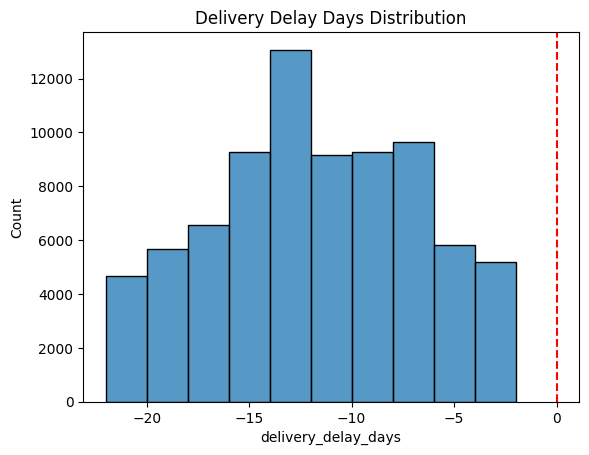

In [22]:
## 배송 지연 분포
sns.histplot(df_no_outlier["delivery_delay_days"].dropna(), bins=10)
plt.axvline(0, color="red", linestyle="--")
plt.title("Delivery Delay Days Distribution")
plt.show()

In [ ]:
df_delayed_30 = df2[df2["delivery_delay_days"] >= 30].copy()

In [108]:
df_delayed_30["order_month"] = (
    df_delayed_30["order_purchase_timestamp"]
    .dt.to_period("M")
    .astype(str)
)

In [110]:
df_delayed_30 = df_delayed_30.merge(
    order_items[["order_id", "product_id"]],
    on="order_id",
    how="left"
)


In [111]:
monthly_category_orders = (
    df_delayed_30
    .groupby(["order_month", "product_category_name"])
    .agg(order_count=("order_id", "nunique"))
    .reset_index()
    .sort_values(["order_month", "order_count"], ascending=[True, False])
)

KeyError: 'product_category_name'

#### 기본 분포 확인

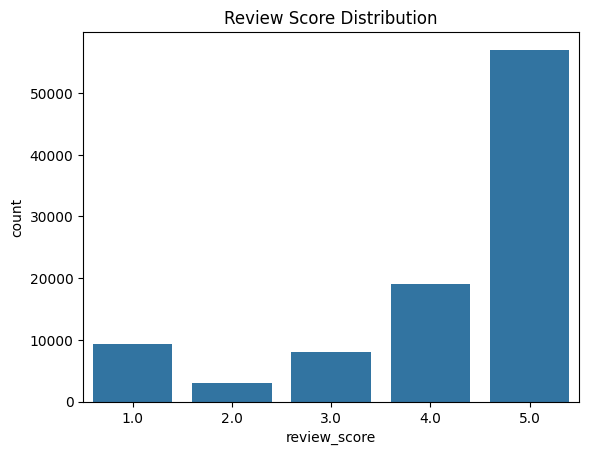

In [43]:
## 리뷰 점수 분포
sns.countplot(data=df2, x="review_score")
plt.title("Review Score Distribution")
plt.show()

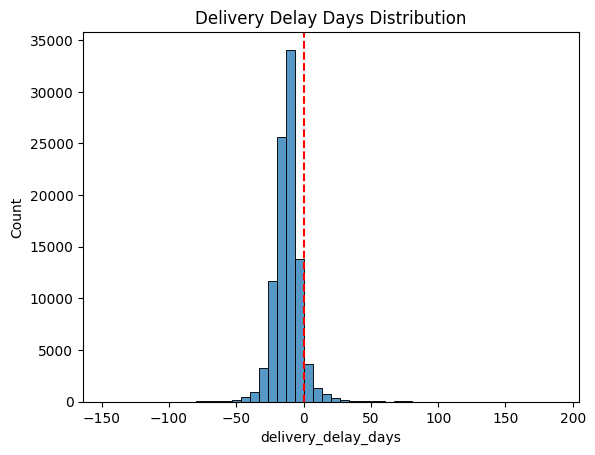

In [44]:
## 배송 지연 분포
sns.histplot(df2["delivery_delay_days"].dropna(), bins=50)
plt.axvline(0, color="red", linestyle="--")
plt.title("Delivery Delay Days Distribution")
plt.show()

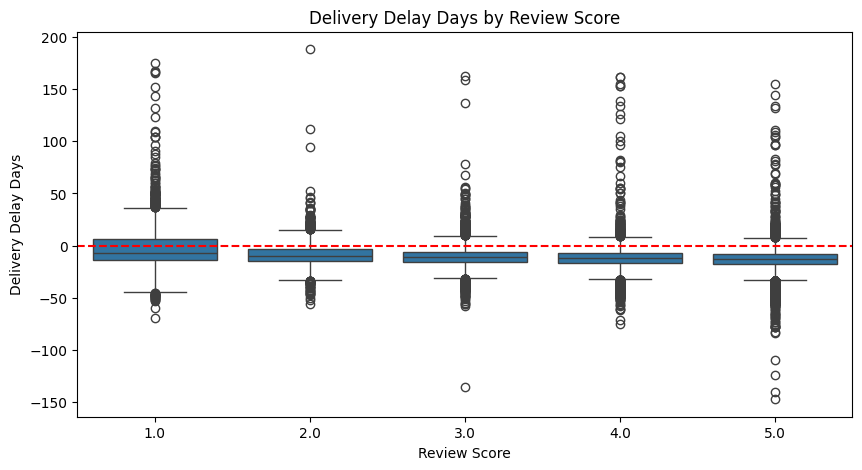

In [45]:
plt.figure(figsize=(10, 5))
sns.boxplot(
    data=df2,
    x="review_score",
    y="delivery_delay_days"
)
plt.axhline(0, color="red", linestyle="--")
plt.title("Delivery Delay Days by Review Score")
plt.xlabel("Review Score")
plt.ylabel("Delivery Delay Days")
plt.show()


**1. 저평점 (1~2점)**
- 50일, 100일 이상 지연된 점들 상대적으로 많다고 볼 수 있나?

**2. 고평점 (4~5점)**
- 지연 사례는 존재함
- 극단적 지연 빈도는 ...??


#### 문제 요인별 EDA (리뷰 전 감지 가능 변수)

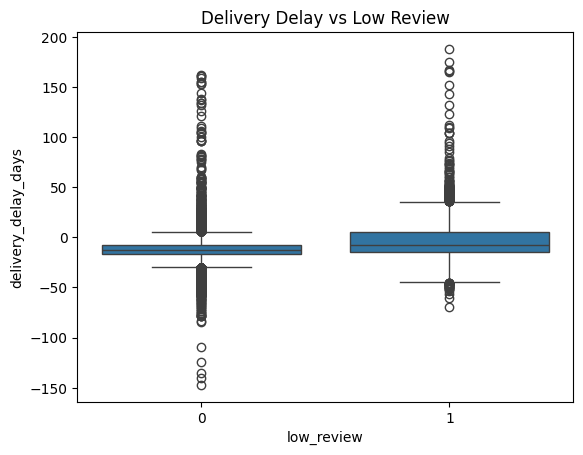

In [46]:
## 배송 지연 vs 리뷰
sns.boxplot(
    data=df2,
    x="low_review",
    y="delivery_delay_days"
)
plt.title("Delivery Delay vs Low Review")
plt.show()


In [47]:
df2.groupby("is_late")["low_review"].mean()

is_late
0    0.092834
1    0.624064
Name: low_review, dtype: float64

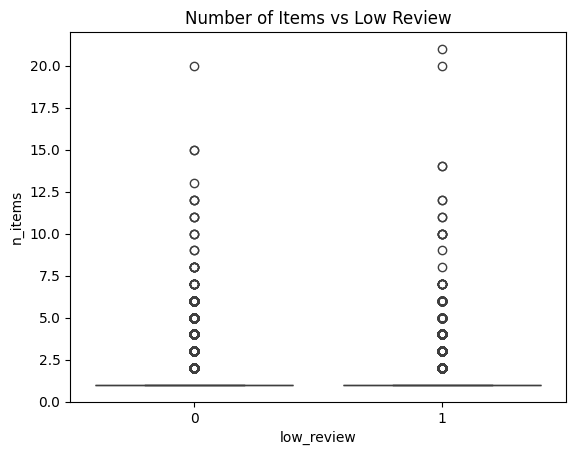

In [50]:
## 주문 구조 (아이템 수, 판매자 수)
sns.boxplot(data=df, x="low_review", y="n_items")
plt.title("Number of Items vs Low Review")
plt.show()


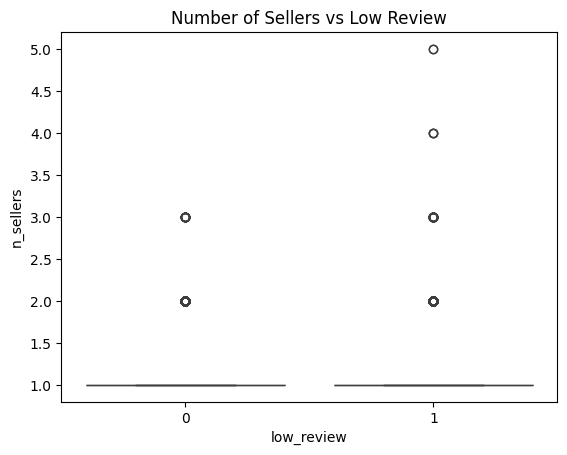

In [51]:
sns.boxplot(data=df, x="low_review", y="n_sellers")
plt.title("Number of Sellers vs Low Review")
plt.show()


대부분의 주문은 단일 판매자로 구성되지만,
복수 판매자가 포함된 주문의 경우 저평점으로 이어질 가능성이 상대적으로 더 높게 나타나는 듯??

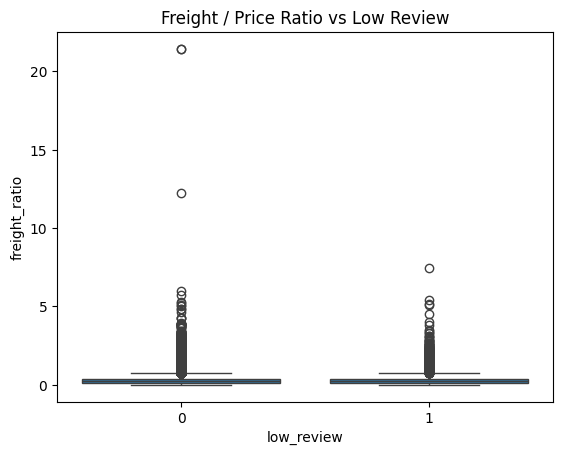

In [52]:
## 배송비 부담
df["freight_ratio"] = df["total_freight"] / df["total_price"]

sns.boxplot(data=df, x="low_review", y="freight_ratio")
plt.title("Freight / Price Ratio vs Low Review")
plt.show()


- 배송비 비중이 높을수록 무조건 저평점은 아님

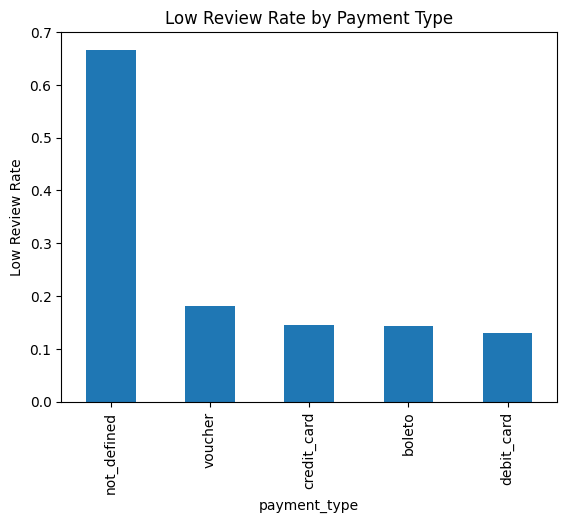

In [53]:
## 결제 수단
payment_review = (
    df.groupby("payment_type")["low_review"]
    .mean()
    .sort_values(ascending=False)
)

payment_review.plot(kind="bar")
plt.title("Low Review Rate by Payment Type")
plt.ylabel("Low Review Rate")
plt.show()


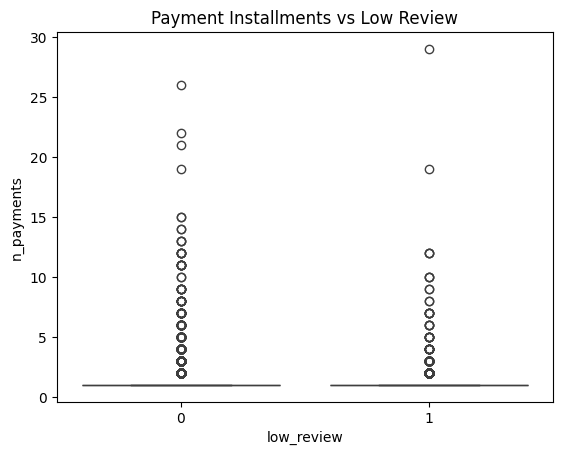

In [54]:
## 분할 결제 여부
sns.boxplot(data=df, x="low_review", y="n_payments")
plt.title("Payment Installments vs Low Review")
plt.show()


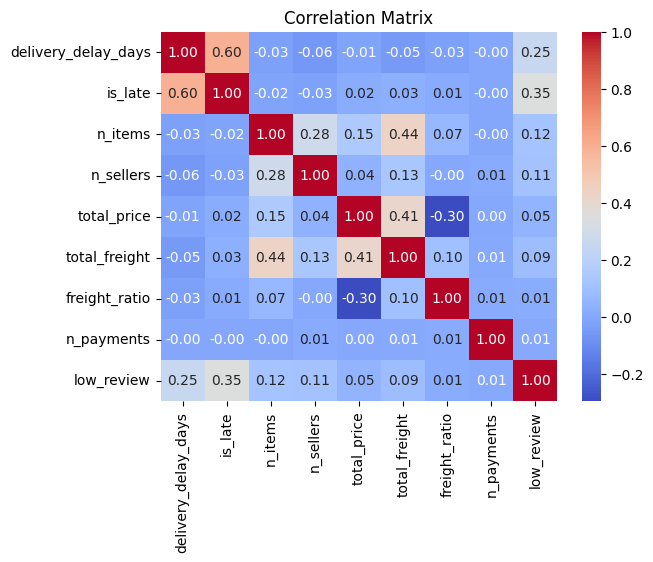

In [55]:
## 상관 구조
feature_cols = [
    "delivery_delay_days",
    "is_late",
    "n_items",
    "n_sellers",
    "total_price",
    "total_freight",
    "freight_ratio",
    "n_payments",
    "low_review"
]

corr = df[feature_cols].corr()

sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


## 추가 EDA

In [23]:
# 데이터 불러오기
orders = pd.read_csv("olist_orders_dataset.csv")
order_items = pd.read_csv("olist_order_items_dataset.csv")
reviews = pd.read_csv("olist_order_reviews_dataset.csv")
sellers = pd.read_csv("olist_sellers_dataset.csv")


In [24]:
# 주문 + 리뷰
df = orders.merge(
    reviews[["order_id", "review_score"]],
    on="order_id",
    how="left"
)

# 주문 + 판매자 (order_items 기준)
df = df.merge(
    order_items[["order_id", "seller_id"]],
    on="order_id",
    how="left"
)

In [25]:
## 배송 관련 파생 변수 생성
date_cols = [
    "order_purchase_timestamp",
    "order_approved_at",
    "order_delivered_carrier_date",
    "order_delivered_customer_date",
    "order_estimated_delivery_date"
]

for col in date_cols:
    df[col] = pd.to_datetime(df[col])

In [26]:
# 출고까지 걸린 시간
df["processing_days"] = (
    df["order_delivered_carrier_date"] - df["order_approved_at"]
).dt.days

# 물류 운송 시간
df["shipping_days"] = (
    df["order_delivered_customer_date"] - df["order_delivered_carrier_date"]
).dt.days

# 배송 지연일
df["delivery_delay"] = (
    df["order_delivered_customer_date"] - df["order_estimated_delivery_date"]
).dt.days

In [27]:
# 출고 지연 여부 (정상 출고: 0 / 지연: 1)
df["shipment_delayed"] = (df["processing_days"] > 2).astype(int)

# 부정리뷰 여부 (긍정(4~5): 0 / 부정(1~3점): 1)
df["negative_review"] = (df["review_score"] <= 3).astype(int)

In [28]:
## 판매자별
seller_profile = (
    df.groupby("seller_id")
    .agg(
        total_orders=("order_id", "count"),
        avg_review_score=("review_score", "mean"),
        negative_review_ratio=("negative_review", "mean"),
        avg_processing_days=("processing_days", "mean"),
        avg_shipping_days=("shipping_days", "mean"),         # 해당 판매자가 처리한 전체 주문 중, 출고 지연된 주문의 비율
        shipment_delay_ratio=("shipment_delayed", "mean"),   # 해당 판매자가 처리한 전체 주문 중, 배송 지연된 주문의 비율
        avg_delivery_delay=("delivery_delay", "mean")        # 판매자별 평균 배송지연일
    )
    .reset_index()
)

In [29]:
seller_profile.describe()

total_orders  avg_review_score  negative_review_ratio  \
count   3095.000000       3090.000000            3095.000000   
mean      36.611955          3.973340               0.255828   
std      120.129664          0.970685               0.278930   
min        1.000000          1.000000               0.000000   
25%        2.000000          3.712470               0.000000   
50%        8.000000          4.166667               0.196517   
75%       24.000000          4.604632               0.333333   
max     2039.000000          5.000000               1.000000   

       avg_processing_days  avg_shipping_days  shipment_delay_ratio  \
count          2977.000000        2970.000000           3095.000000   
mean              2.722752           8.088521              0.309942   
std               3.949356           5.680744              0.326164   
min             -18.375000          -5.000000              0.000000   
25%               0.875000           5.166667              0.000000   
50%               1.680000           7.444444              0.207207   
75%               3.066667           9.954004              0.500000   
max              61.000000         186.000000              1.000000   

       avg_delivery_delay  
count         2970.000000  
mean           -12.287906  
std              7.999842  
min            -66.000000  
25%            -15.448661  
50%            -12.000000  
75%             -9.000000  
max            167.000000

In [30]:
seller_profile.isna().sum()

seller_id                  0
total_orders               0
avg_review_score           5
negative_review_ratio      0
avg_processing_days      118
avg_shipping_days        125
shipment_delay_ratio       0
avg_delivery_delay       125
dtype: int64

In [31]:
# total order = 0 인 seller 찾기 : 없음 (당연함;;; 바본가)
#seller_profile[seller_profile['total_orders'] == 1 ]

In [32]:
## 유의 판매자 정의 (중앙값 기준)
seller_profile["problem_seller"] = (
    (seller_profile["negative_review_ratio"] > 0.19) |
    (seller_profile["shipment_delay_ratio"] > 0.20) #|
    #(seller_profile["avg_review_score"] < 3.5)
).astype(int)


In [33]:
seller_profile["problem_seller"].value_counts(normalize=True)

problem_seller
1    0.713409
0    0.286591
Name: proportion, dtype: float64

#### 판매자 리스크 분포 시각화

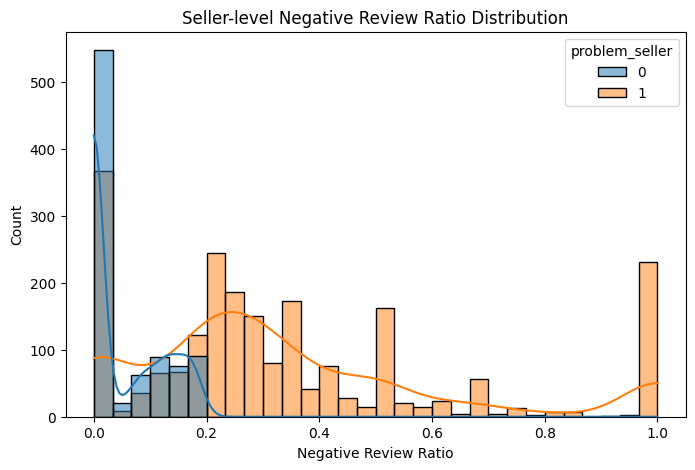

In [34]:
## 부정 리뷰 비율 분포
plt.figure(figsize=(8,5))
sns.histplot(
    data=seller_profile,
    x="negative_review_ratio",
    hue="problem_seller",
    bins=30,
    kde=True
)
plt.title("Seller-level Negative Review Ratio Distribution")
plt.xlabel("Negative Review Ratio")
plt.show()


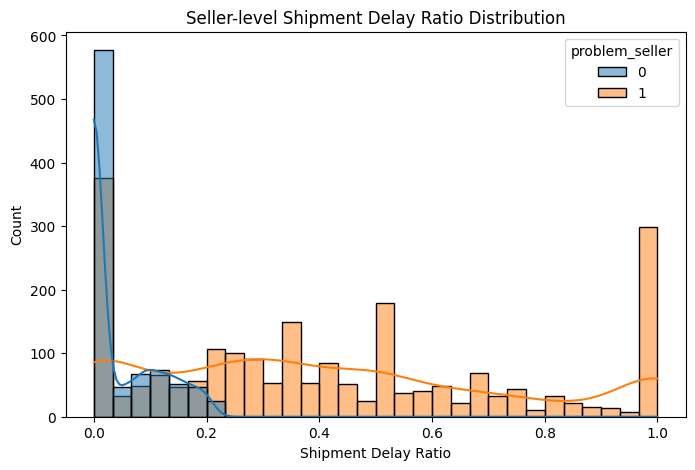

In [35]:
## 출고 지연률 분포
plt.figure(figsize=(8,5))
sns.histplot(
    data=seller_profile,
    x="shipment_delay_ratio",
    hue="problem_seller",
    bins=30,
    kde=True
)
plt.title("Seller-level Shipment Delay Ratio Distribution")
plt.xlabel("Shipment Delay Ratio")
plt.show()


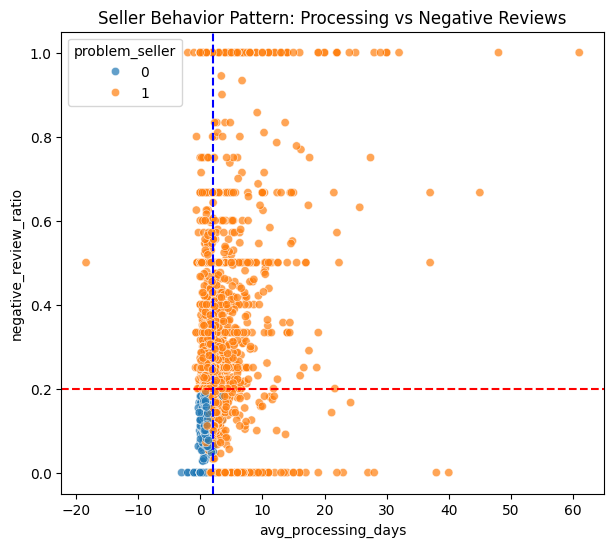

In [36]:
## 평균 처리 시간 vs 부정 리뷰 비율
plt.figure(figsize=(7,6))
sns.scatterplot(
    data=seller_profile,
    x="avg_processing_days",
    y="negative_review_ratio",
    hue="problem_seller",
    alpha=0.7
)
plt.axhline(0.20, color="red", linestyle="--")
plt.axvline(2, color="blue", linestyle="--")
plt.title("Seller Behavior Pattern: Processing vs Negative Reviews")
plt.show()


In [37]:
## 판매자 리스크 클러스터 구조 확인
features_for_cluster = seller_profile[
    [
        "negative_review_ratio",
        "shipment_delay_ratio",
        "avg_processing_days",
        "avg_shipping_days"
    ]
].fillna(0)


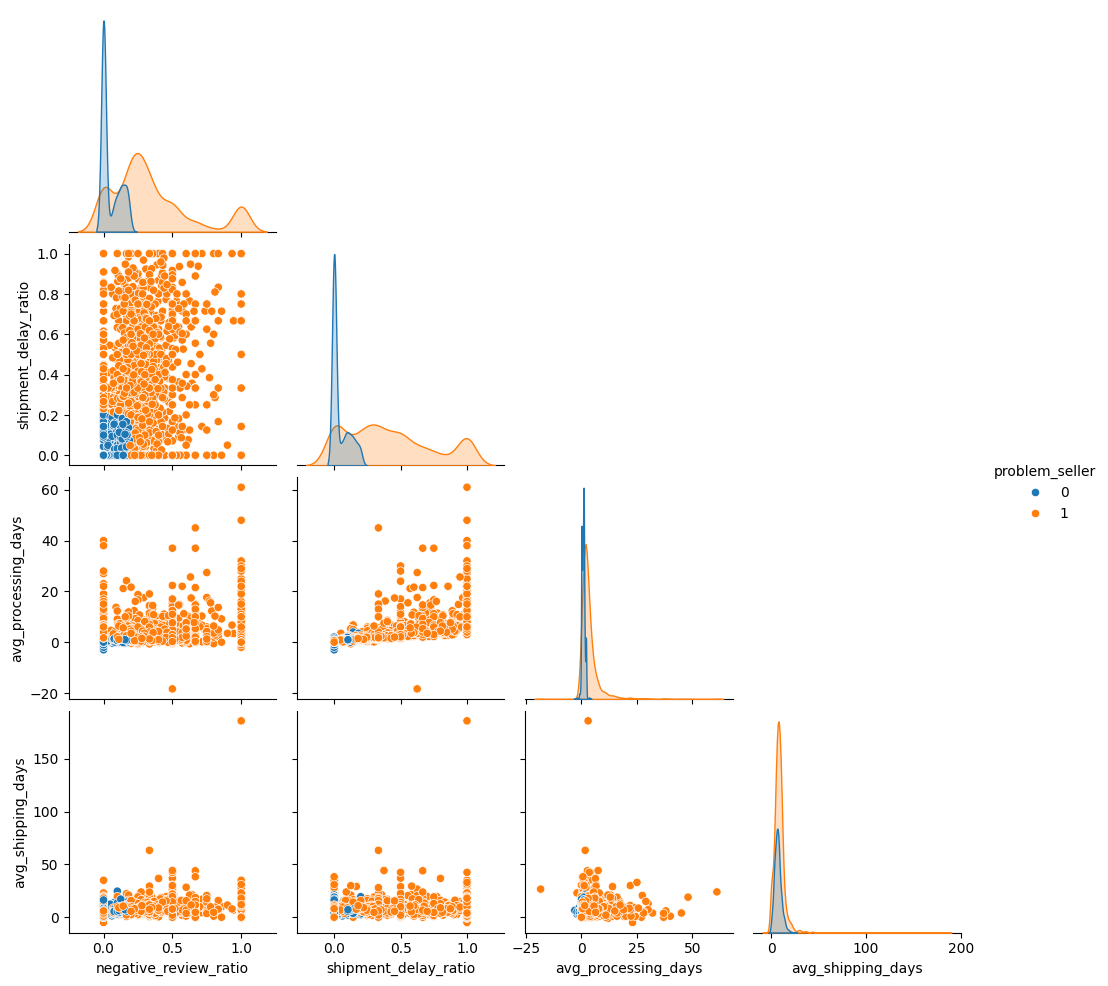

In [38]:
sns.pairplot(
    features_for_cluster.join(seller_profile["problem_seller"]),
    hue="problem_seller",
    corner=True
)
plt.show()


In [39]:
## 상위 위험 판매자 top 20
seller_profile.sort_values(
    "negative_review_ratio",
    ascending=False
).head(20)


seller_id  total_orders  avg_review_score  \
2     001e6ad469a905060d959994f1b41e4f             1               1.0   
12    010da0602d7774602cd1b3f5fb7b709e             5               1.0   
3090  ffcfefa19b08742c5d315f2791395ee5             1               1.0   
621   344223b2a90784f64136a8a5da012e7f             1               2.0   
627   34aefe746cd81b7f3b23253ea28bef39             1               1.0   
653   37ceb404da208418c9032f0674e57804             3               1.0   
667   391bbd13b6452244774beff1824006ed             2               1.0   
689   3a52d63a8f9daf5a28f3626d7eb9bd28             1               1.0   
691   3a79f35a2344ede41af21267f61d5ec6             1               1.0   
705   3bfad056cf05c00dabe2f895925d83b1             5               1.0   
733   3da38366e7bd9baf6369071f782ecdf0             1               1.0   
2911  f114dca2828bf718548db175ebe2cfcd             1               1.0   
2937  f3055483058c84d75ca2a3314fb4deef             1               1.0   
2954  f43827dd686be3a4a80e00aa299990fb             2               2.0   
2965  f524ad65d7e0f1daab730ef2d2e86196             2               1.0   
2967  f5403d3f50089112c4eed37928b7f622             2               1.0   
38    0336182e1b3e92f029d5354832045fdf             2               2.0   
751   3f8247d0f772ffa58560e5c682521ad5             1               3.0   
761   3febca52652e7209509ccfe61cbde40e             2               2.0   
763   4003520d80d0bad1d5623f7aa3c63cda             1               1.0   

      negative_review_ratio  avg_processing_days  avg_shipping_days  \
2                       1.0                  NaN                NaN   
12                      1.0                 20.0                4.0   
3090                    1.0                  NaN                NaN   
621                     1.0                  5.0               27.0   
627                     1.0                  NaN                NaN   
653                     1.0                  NaN                NaN   
667                     1.0                 14.0               29.0   
689                     1.0                  1.0                4.0   
691                     1.0                  4.0                8.0   
705                     1.0                  NaN                NaN   
733                     1.0                 22.0               30.0   
2911                    1.0                  2.0                7.0   
2937                    1.0                  NaN                NaN   
2954                    1.0                 10.0               10.0   
2965                    1.0                  6.0               18.0   
2967                    1.0                  NaN                NaN   
38                      1.0                  8.0                3.0   
751                     1.0                  NaN                NaN   
761                     1.0                  NaN                NaN   
763                     1.0                  1.0               15.0   

      shipment_delay_ratio  avg_delivery_delay  problem_seller  
2                      0.0                 NaN               1  
12                     1.0               -10.0               1  
3090                   0.0                 NaN               1  
621                    1.0                 0.0               1  
627                    0.0                 NaN               1  
653                    0.0                 NaN               1  
667                    0.5                24.0               1  
689                    0.0               -41.0               1  
691                    1.0                -8.0               1  
705                    0.0                 NaN               1  
733                    1.0                 6.0               1  
2911                   0.0               -22.0               1  
2937                   0.0                 NaN               1  
2954                   1.0               -14.0               1  
2965   

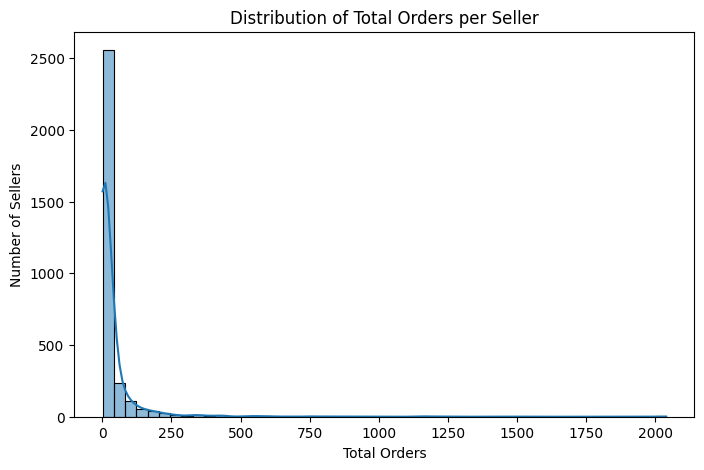

In [40]:
## 총 주문 건수 분포
# 대부분 주문량이 그렇게 많지 않음. 1-2건 주문으로 리뷰 안 좋게 받아서 유의 판매자 될 수 있음
# 이런 판매자를 유의판매자로 볼 수 있는지?
plt.figure(figsize=(8,5))
sns.histplot(
    seller_profile["total_orders"],
    bins=50,
    kde=True
)
plt.title("Distribution of Total Orders per Seller")
plt.xlabel("Total Orders")
plt.ylabel("Number of Sellers")
plt.show()

#### 텍스트 리뷰 지표로 포함 EDA

In [64]:
## 데이터 다시 불러오기
orders = pd.read_csv("olist_orders_dataset.csv")
order_items = pd.read_csv("olist_order_items_dataset.csv")
reviews = pd.read_csv("olist_order_reviews_dataset.csv")

In [65]:
pd.set_option('display.max_rows', None)
reviews['review_comment_message']

0                                                      NaN
1                                                      NaN
2                                                      NaN
3                    Recebi bem antes do prazo estipulado.
4        Parabéns lojas lannister adorei comprar pela I...
5                                                      NaN
6                                                      NaN
7                                                      NaN
8                                                      NaN
9        aparelho eficiente. no site a marca do aparelh...
10                                                     NaN
11                                                     NaN
12         Mas um pouco ,travando...pelo valor ta Boa.\r\n
13                                                     NaN
14                                                     NaN
15       Vendedor confiável, produto ok e entrega antes...
16       GOSTARIA DE SABER O QUE HOUVE, SEMPRE RECEBI E.

In [66]:
## 주문-리뷰-판매자 데이터 합치기
df = orders.merge(
    reviews[[
        "order_id",
        "review_score",
        "review_comment_message"
    ]],
    on="order_id",
    how="left"
)

df = df.merge(
    order_items[["order_id", "seller_id"]],
    on="order_id",
    how="left"
)


In [67]:
## 날짜형 변수 변환
date_cols = [
    "order_purchase_timestamp",
    "order_approved_at",
    "order_delivered_carrier_date",
    "order_delivered_customer_date",
    "order_estimated_delivery_date"
]

for col in date_cols:
    df[col] = pd.to_datetime(df[col])

In [68]:
## 배송 관련 변수 생성
df["processing_days"] = (
    df["order_delivered_carrier_date"] - df["order_approved_at"]
).dt.days

df["shipping_days"] = (
    df["order_delivered_customer_date"] - df["order_delivered_carrier_date"]
).dt.days

df["delivery_delay"] = (
    df["order_delivered_customer_date"] - df["order_estimated_delivery_date"]
).dt.days

In [69]:
# 배송/처리일이 음수인 경우가 있을 수 있으므로 확인
cols_check = ["processing_days", "shipping_days", "delivery_delay"]
print(df[cols_check].describe())

# 음수값 비율 확인
for c in cols_check:
    neg_ratio = (df[c] < 0).mean()
    print(f"{c} negative ratio: {neg_ratio:.4f}")

       processing_days  shipping_days  delivery_delay
count    112097.000000  110838.000000   110839.000000
mean          2.350295       8.735596      -12.035809
std           3.597744       8.607490       10.159965
min        -172.000000     -17.000000     -147.000000
25%           0.000000       4.000000      -17.000000
50%           1.000000       7.000000      -13.000000
75%           3.000000      11.000000       -7.000000
max         125.000000     205.000000      188.000000
processing_days negative ratio: 0.0136
shipping_days negative ratio: 0.0004
delivery_delay negative ratio: 0.8947


In [70]:
## 음수인 건 잘못 찍힌 데이터일 수 있음 -> 이상치 제거
df = df[
    (df["processing_days"] >= 0) &
    (df["shipping_days"] >= 0)
]

In [71]:
## 확인 => 잘 지워짐
print("processing_days 음수 비율:", (df["processing_days"] < 0).mean())
print("shipping_days 음수 비율:", (df["shipping_days"] < 0).mean())

processing_days 음수 비율: 0.0
shipping_days 음수 비율: 0.0


In [72]:
## 리뷰, 출고 관련 이진 변수 생성
df["shipment_delayed"] = (df["processing_days"] > 2).astype(int)
df["negative_review"] = (df["review_score"] <= 3).astype(int)

In [73]:
# 텍스트 존재 여부
df["has_review_text"] = df["review_comment_message"].notna().astype(int)

In [74]:
# 리뷰 길이
df["review_length"] = (
    df["review_comment_message"]
    .fillna("")
    .str.len()
)

#### 불만 키워드 기반 분석

In [76]:
## 댓글 표준화

import unicodedata
import re

def normalize_text(text):
    if pd.isna(text):
        return ""
    text = text.lower()
    text = unicodedata.normalize("NFD", text)
    text = "".join(c for c in text if unicodedata.category(c) != "Mn")
    text = re.sub(r"[^a-z\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text


In [77]:
df["review_text_norm"] = df["review_comment_message"].apply(normalize_text)

In [ ]:
'''
complaint_keywords = {
    "delivery": [
        "delay", "late",
        "demora", "atraso", "atrasado",
        "nao chegou", "nao recebi", "nao entregue"
    ],
    "product": [
        "defect", "broken", "wrong", "damaged",
        "defeito", "quebrado", "danificado",
        "produto errado", "veio errado",
        "faltando", "incompleto"
    ],
    "seller": [
        "seller", "support", "response", "answer",
        "atendimento", "resposta", "nao responde",
        "mau atendimento", "pessimo atendimento"
    ],
    "refund": [
        "refund", "return", "money",
        "reembolso", "devolucao", "devolver",
        "sem reembolso", "nao devolveu"
    ]
}
'''

complaint_keywords = {
    "delivery": [
        "delay", "late",
        "demora", "atraso",                          # 지연에 관한 단어
        "nao chegou", "nao recebi", "nao entregue"   # 도착하지 않음, 받지 못함, 배송되지 않음
    ],
    "product": [
        "defect", "broken", "wrong", "damaged",       # 불량, 파손, 잘못된, 손상된
        "defeito", "quebrado", "danificado",          # 결함, 깨짐, 손상
        "produto errado", "veio errado"               # 잘못된 상품, 잘못 배송됨
    ],
    "seller": [
        "atendimento", "resposta", "nao responde",     # 고객 응대, 서비스, 답변, 답변하지 않음
        "mau atendimento", "pessimo atendimento"       # 나쁜 서비스, 최악의 서비스
    ],
    "refund": [
        "reembolso", "devolucao", "devolver",          # 환불, 반품, 반환하다
        "nao devolveu", "sem reembolso"                # 반환하지 않음, 환불 없음
    ]
}

for cat, kws in complaint_keywords.items():
    pattern = "|".join([re.escape(k) for k in kws])  
    df[f"complaint_{cat}"] = df["review_text_norm"].str.contains(pattern, na=False).astype(int)


In [84]:
seller_profile = (
    df.groupby("seller_id")
    .agg(
        total_orders=("order_id", "count"),

        # 리뷰 기반
        avg_review_score=("review_score", "mean"),
        negative_review_ratio=("negative_review", "mean"),

        # 텍스트 기반
        text_review_ratio=("has_review_text", "mean"),
        avg_review_length=("review_length", "mean"),
        long_review_ratio=("review_length", lambda x: (x > 100).mean()),

        # 배송/판매자 행동 기반
        avg_processing_days=("processing_days", "mean"),
        avg_shipping_days=("shipping_days", "mean"),
        shipment_delay_ratio=("shipment_delayed", "mean"),
        avg_delivery_delay=("delivery_delay", "mean"),

        # 불만 주제 비율
        complaint_delivery=("complaint_delivery", "mean"),
        complaint_product=("complaint_product", "mean"),
        complaint_seller=("complaint_seller", "mean"),
        complaint_refund=("complaint_refund", "mean")
    )
    .reset_index()
)


#### 시각화

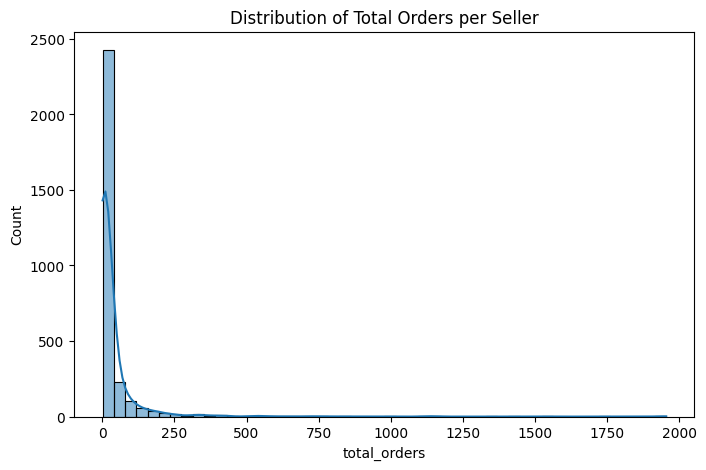

In [85]:
## 주문 건수 분포
plt.figure(figsize=(8,5))
sns.histplot(seller_profile["total_orders"], bins=50, kde=True)
plt.title("Distribution of Total Orders per Seller")
plt.xlabel("total_orders")
plt.show()

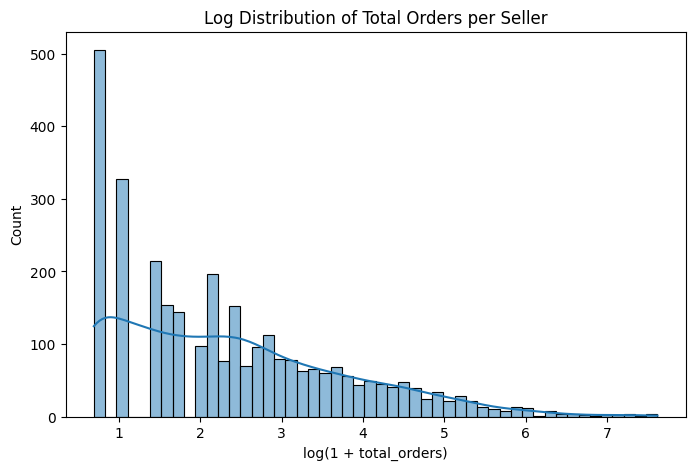

In [78]:
## 주문 건수 분포 (로그스케일)
plt.figure(figsize=(8,5))
sns.histplot(np.log1p(seller_profile["total_orders"]), bins=50, kde=True)
plt.title("Log Distribution of Total Orders per Seller")
plt.xlabel("log(1 + total_orders)")
plt.show()

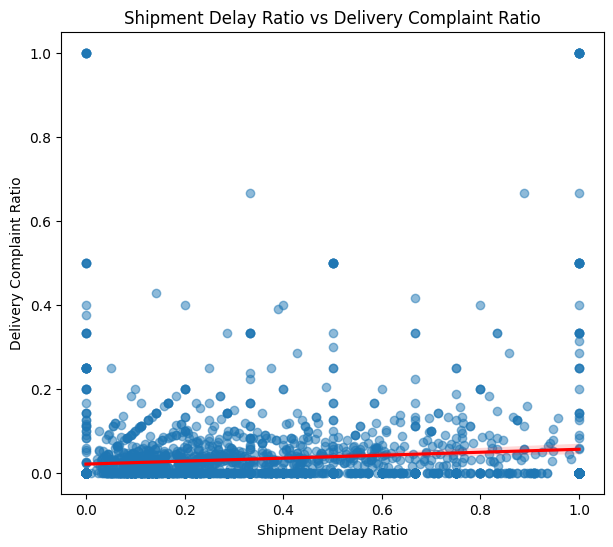

In [89]:
## 츨고 지연률 vs 배송 불만 텍스트
plt.figure(figsize=(7,6))
sns.regplot(
    data=seller_profile,
    x="shipment_delay_ratio",
    y="complaint_delivery",
    scatter_kws={"alpha":0.5},
    line_kws={"color":"red"}
)
plt.title("Shipment Delay Ratio vs Delivery Complaint Ratio")
plt.xlabel("Shipment Delay Ratio")
plt.ylabel("Delivery Complaint Ratio")
plt.show()


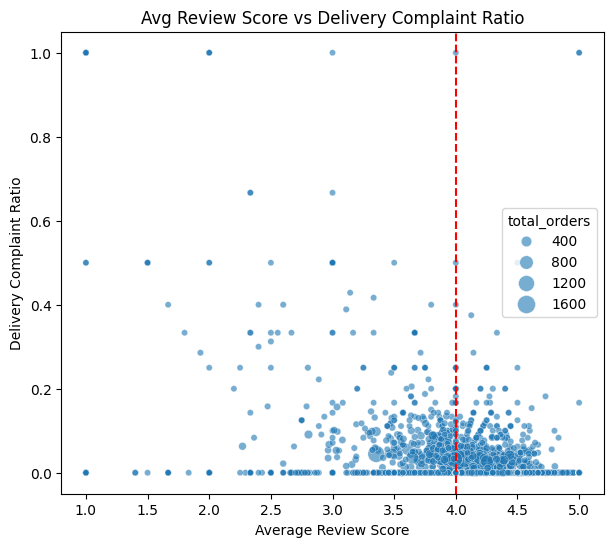

In [ ]:
## 리뷰 점수 vs 텍스트 불만
# 평점은 괜찮은데 배송 불만은 많은 판매자가 존재함
plt.figure(figsize=(7,6))
sns.scatterplot(
    data=seller_profile,
    x="avg_review_score",
    y="complaint_delivery",
    size="total_orders",
    sizes=(20, 200),
    alpha=0.6
)
plt.axvline(4.0, color="red", linestyle="--")
plt.title("Avg Review Score vs Delivery Complaint Ratio")
plt.xlabel("Average Review Score")
plt.ylabel("Delivery Complaint Ratio")
plt.show()


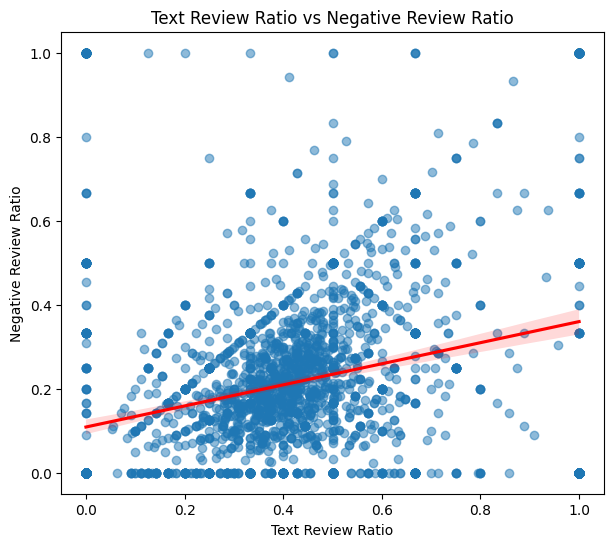

In [ ]:
## 텍스트 리뷰 비율 vs 부정 리뷰 비율
# 불만이 있을수록 텍스트를 쓴다
plt.figure(figsize=(7,6))
sns.regplot(
    data=seller_profile,
    x="text_review_ratio",
    y="negative_review_ratio",
    scatter_kws={"alpha":0.5},
    line_kws={"color":"red"}
)
plt.title("Text Review Ratio vs Negative Review Ratio")
plt.xlabel("Text Review Ratio")
plt.ylabel("Negative Review Ratio")
plt.show()


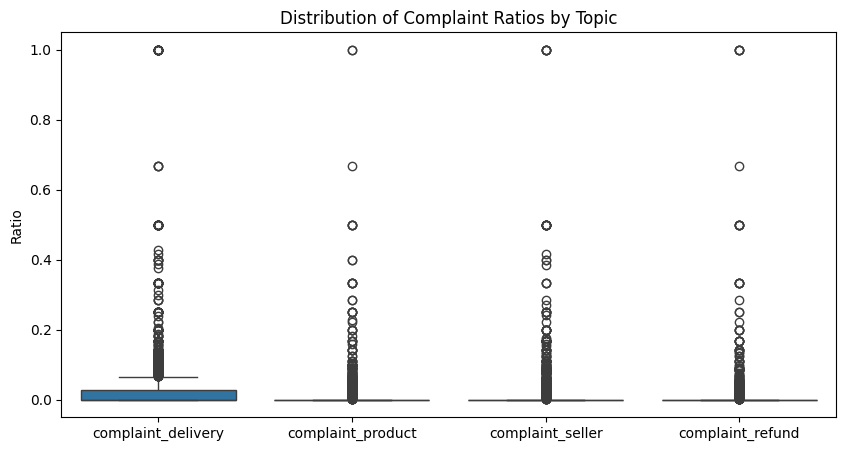

In [92]:
## 텍스트 불만 주제별 비교
plt.figure(figsize=(10,5))
sns.boxplot(
    data=seller_profile[
        ["complaint_delivery", "complaint_product",
         "complaint_seller", "complaint_refund"]
    ]
)
plt.title("Distribution of Complaint Ratios by Topic")
plt.ylabel("Ratio")
plt.show()


In [86]:
## 상관분석
corr_cols = [
    "negative_review_ratio",
    "avg_review_score",
    "shipment_delay_ratio",
    "avg_processing_days",
    "avg_shipping_days",
    "avg_delivery_delay",
    "text_review_ratio",
    "long_review_ratio",
    "complaint_delivery",
    "complaint_product",
    "complaint_seller",
    "complaint_refund",
    "total_orders"
]

corr_df = seller_profile[corr_cols]


<Axes: >

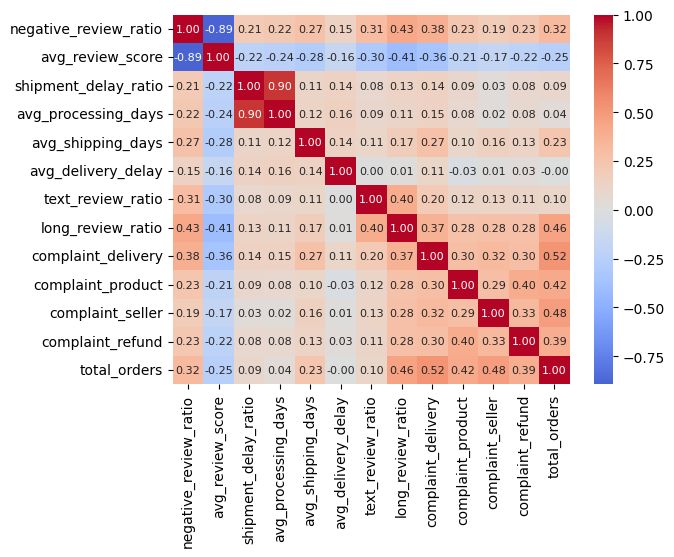

In [88]:
corr_matrix = corr_df.corr(method="spearman")

sns.heatmap(
    corr_matrix,
    cmap="coolwarm",
    center=0,
    annot=True,
    fmt=".2f",
    annot_kws={"size": 8}
)


In [101]:
## 점수는 괜찮은데 불만 텍스트가 많은 불일치 판매자 탐색
mismatch = seller_profile[
    (seller_profile["avg_review_score"] >= 4.0) &
    (seller_profile["complaint_delivery"] >= 0.20) &
    (seller_profile["total_orders"] >= 10)
].sort_values(["complaint_delivery", "total_orders"], ascending=False)

mismatch


seller_id  total_orders  avg_review_score  \
1212  67bf6941ba2f1fa1d02c375766bc3e53            20               4.3   
2371  cb9fb4ca75d7ba8437480e8dde64fe98            10               4.0   

      negative_review_ratio  text_review_ratio  avg_review_length  \
1212                    0.3                0.5               52.8   
2371                    0.2                0.7               64.1   

      long_review_ratio  avg_processing_days  avg_shipping_days  \
1212                0.3                 1.25               9.65   
2371                0.3                 0.80               7.30   

      shipment_delay_ratio  avg_delivery_delay  complaint_delivery  \
1212                   0.2               -10.2                 0.2   
2371                   0.1               -11.7                 0.2   

      complaint_product  complaint_seller  complaint_refund  
1212                0.0               0.0               0.0  
2371                0.0               0.0               0.0

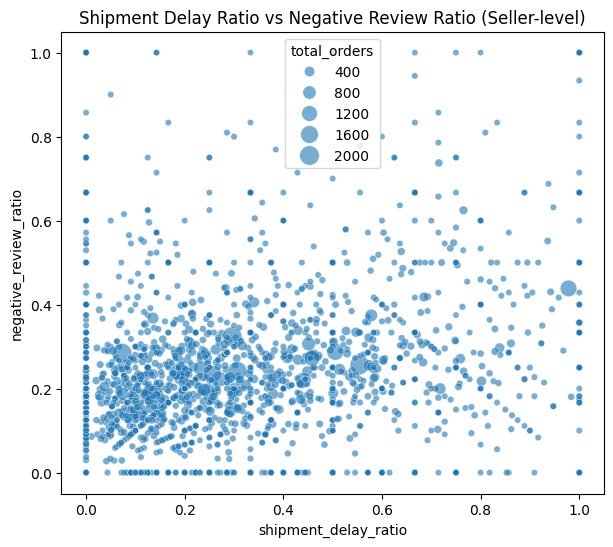

In [79]:
## 출고 지연률 vs 부정리뷰 비율
plt.figure(figsize=(7,6))
sns.scatterplot(
    data=seller_profile,
    x="shipment_delay_ratio",
    y="negative_review_ratio",
    size="total_orders",
    sizes=(20, 200),
    alpha=0.6
)
plt.title("Shipment Delay Ratio vs Negative Review Ratio (Seller-level)")
plt.xlabel("shipment_delay_ratio")
plt.ylabel("negative_review_ratio")
plt.show()


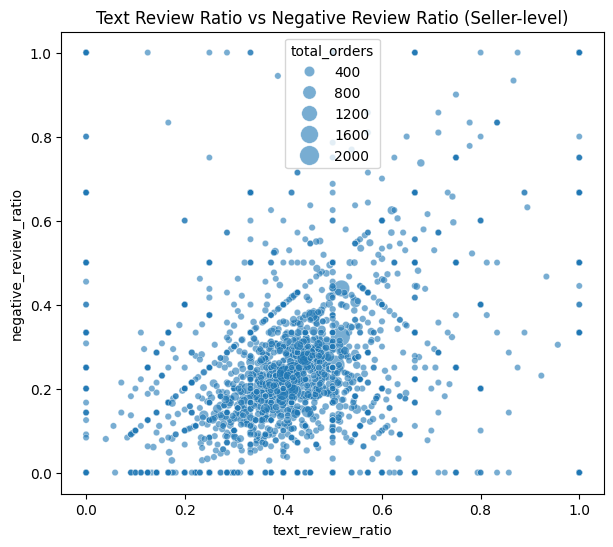

In [80]:
## 텍스트 리뷰 비율 vs 부정리뷰 비율
plt.figure(figsize=(7,6))
sns.scatterplot(
    data=seller_profile,
    x="text_review_ratio",
    y="negative_review_ratio",
    size="total_orders",
    sizes=(20, 200),
    alpha=0.6
)
plt.title("Text Review Ratio vs Negative Review Ratio (Seller-level)")
plt.xlabel("text_review_ratio")
plt.ylabel("negative_review_ratio")
plt.show()


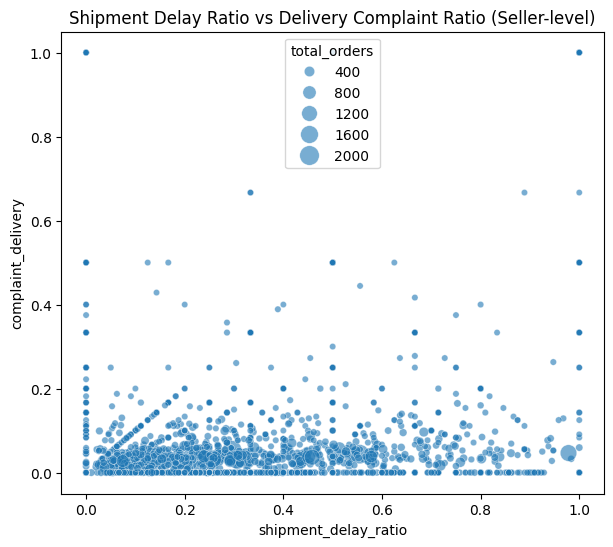

In [81]:
## 불만 주제(배송) 비율 vs 출고 지연률
plt.figure(figsize=(7,6))
sns.scatterplot(
    data=seller_profile,
    x="shipment_delay_ratio",
    y="complaint_delivery",
    size="total_orders",
    sizes=(20, 200),
    alpha=0.6
)
plt.title("Shipment Delay Ratio vs Delivery Complaint Ratio (Seller-level)")
plt.xlabel("shipment_delay_ratio")
plt.ylabel("complaint_delivery")
plt.show()


#### 일단 보류

In [51]:
complaint_keywords = {
    "delivery": [
        "delay", "late",
        "demora", "atraso",
        "nao chegou", "nao recebi", "nao entregue"
    ],
    "product": [
        "defect", "broken", "wrong", "damaged",
        "defeito", "quebrado", "danificado",
        "produto errado", "veio errado"
    ],
    "seller": [
        "atendimento", "resposta", "nao responde",
        "mau atendimento", "pessimo atendimento"
    ],
    "refund": [
        "reembolso", "devolucao", "devolver",
        "nao devolveu", "sem reembolso"
    ]
}

In [52]:
for category, keywords in complaint_keywords.items():
    df[f"complaint_{category}"] = (
        df["review_text_norm"]
        .str.contains("|".join(keywords), na=False)
        .astype(int)
    )

In [53]:
seller_profile = (
    df.groupby("seller_id")
    .agg(
        total_orders=("order_id", "count"),
        avg_review_score=("review_score", "mean"),
        negative_review_ratio=("negative_review", "mean"),
        text_review_ratio=("has_review_text", "mean"),
        avg_review_length=("review_length", "mean"),
        long_review_ratio=("review_length", lambda x: (x > 100).mean()),
        avg_processing_days=("processing_days", "mean"),
        avg_shipping_days=("shipping_days", "mean"),
        shipment_delay_ratio=("shipment_delayed", "mean"),
        avg_delivery_delay=("delivery_delay", "mean"),
        complaint_delivery=("complaint_delivery", "mean"),
        complaint_product=("complaint_product", "mean"),
        complaint_seller=("complaint_seller", "mean"),
        complaint_refund=("complaint_refund", "mean")
    )
    .reset_index()
)


In [54]:
seller_profile["problem_seller_text"] = (
    (seller_profile["negative_review_ratio"] > 0.20) |
    (seller_profile["shipment_delay_ratio"] > 0.15) |
    (seller_profile["avg_review_score"] < 3.5) |
    (seller_profile["complaint_delivery"] > 0.20) |
    (seller_profile["long_review_ratio"] > 0.20)
).astype(int)


In [55]:
seller_profile.describe()


total_orders  avg_review_score  negative_review_ratio  \
count   3095.000000       3090.000000            3095.000000   
mean      36.611955          3.973340               0.255828   
std      120.129664          0.970685               0.278930   
min        1.000000          1.000000               0.000000   
25%        2.000000          3.712470               0.000000   
50%        8.000000          4.166667               0.196517   
75%       24.000000          4.604632               0.333333   
max     2039.000000          5.000000               1.000000   

       text_review_ratio  avg_review_length  long_review_ratio  \
count        3095.000000        3095.000000        3095.000000   
mean            0.416093          30.285992           0.106887   
std             0.290586          31.173505           0.187471   
min             0.000000           0.000000           0.000000   
25%             0.250000           9.975000           0.000000   
50%             0.400000          24.830189           0.041667   
75%             0.541104          39.013158           0.129032   
max             1.000000         204.000000           1.000000   

       avg_processing_days  avg_shipping_days  shipment_delay_ratio  \
count          2977.000000        2970.000000           3095.000000   
mean              2.722752           8.088521              0.309942   
std               3.949356           5.680744              0.326164   
min             -18.375000          -5.000000              0.000000   
25%               0.875000           5.166667              0.000000   
50%               1.680000           7.444444              0.207207   
75%               3.066667           9.954004              0.500000   
max              61.000000         186.000000              1.000000   

       avg_delivery_delay  complaint_delivery  complaint_product  \
count         2970.000000         3095.000000        3095.000000   
mean           -12.287906            0.047910           0.006969   
std              7.999842            0.141821           0.042329   
min            -66.000000            0.000000           0.000000   
25%            -15.448661            0.000000           0.000000   
50%            -12.000000            0.000000           0.000000   
75%             -9.000000            0.035714           0.000000   
max            167.000000            1.000000           1.000000   

       complaint_seller  complaint_refund  problem_seller_text  
count       3095.000000       3095.000000          3095.000000  
mean           0.013625          0.007979             0.742488  
std            0.069571          0.055977             0.437334  
min            0.000000          0.000000             0.000000  
25%            0.000000          0.000000             0.000000  
50%            0.000000          0.000000             1.000000  
75%            0.000000          0.000000             1.000000  
max            1.000000          1.000000             1.000000

In [56]:
seller_profile["problem_seller_text"].value_counts(normalize=True)


problem_seller_text
1    0.742488
0    0.257512
Name: proportion, dtype: float64